# Pycle demo 2: using sketching to protect privacy
In this notebook we demonstrate how Differential Privacy [1] can be guaranteed on top op sketching with `pycle` . We will:
0. Generate a GMM toy example dataset.
1. Compute the *private sketch* of this dataset (for some differential privacy parameters $\epsilon,\delta$).
2. Privately learn from this sketch both several Gaussian mixture models and k-means centroids.

We assume that you have installed `pycle` with `pip` or that you have the `pycle` folder in the same directory as this notebook.


[1] We use the Approximate Differential Privacy guarantee, from C. Dwork, "Calibrating Noise to Sensitivity in Private Data Analysis", https://people.csail.mit.edu/asmith/PS/sensitivity-tcc-final.pdf 

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
np.random.seed(42)

Once again, we generate a simple synthetic dataset from a GMM, this time in 10 dimensions.

In [2]:
from pycle.utils import generatedataset_GMM

d = 10     # Dimension
K = 5      # Number of Gaussians
n = 200000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
X = generatedataset_GMM(d,K,n,normalize='l_inf-unit-ball',balanced=False) 

We also define our privacy requirements. Suppose we want approximate differential privacy with $\epsilon = 10^{-2}$ and $\delta = 10^{-7}$.

In [3]:
epsilon = 1e-2
delta = 1e-7

To sketch with differential privacy, we simply call `sk.computeSketch_DP` instead of `sk.computeSketch`.

Note that we also demonstrate here how we can also the sketch function by multiply by normalization constant, e.g. $\frac{1}{\sqrt{m}}$.

In [4]:
import pycle.sketching as sk

m = 20*K*d 
Sigma = 0.05*np.eye(d) # Assumed known a priori!
Omega = sk.drawFrequencies("AR",d,m,Sigma)
Phi = sk.SimpleFeatureMap("ComplexExponential",Omega, c_norm=1/np.sqrt(m)) # Normalization constant

# The only change is that we don't call computeSketch but computeSketch_DP, and input (epsilon,delta)
z = sk.computeSketch_DP(X,Phi,epsilon,delta)

Having computed `z`, we can learn from it as many times as we want, without breaking privacy (DP is robust to post-processing). In this example, we learn both K-means and a GMM mixture from the same sketch without having to split the privacy budget. Note also that we run several trials of compressive GMM fitting, again without having to split the privacy budget. 

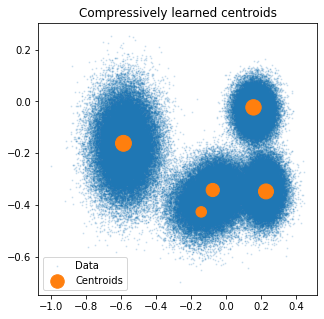

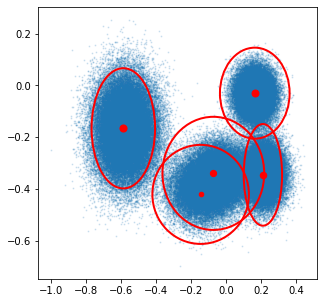

In [5]:
import pycle.compressive_learning as cl
from pycle.utils import plotGMM

# K-means
(weights,centroids) = cl.CLOMPR_CKM(z,Phi,K)
# Visualize the centroids (we re-use the dataset for visual comparison)
plt.figure(figsize=(5,5))
plt.title("Compressively learned centroids")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.15)
plt.scatter(centroids[:,0],centroids[:,1],s=1000*weights)
plt.legend(["Data","Centroids"])
plt.show()

# GMM
GMM = cl.CLOMPR_GMM(z,Phi,K,bestOfRuns=5) 
plotGMM(X,GMM)